---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, abordarei o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. 

Em pesquisa realizada pela CNDL/SPC Brasil, em parceria com o Sebrae, indica que 59% dos entrevistados sofreram algum tipo de fraude em 2020, contra 46% em 2019 (crescimento de 13 p.p.) - **clonagem de cartão foi o terceiro maior motivo** com 24% das menções.
 
**Destaques apontados pela pesquisa:**
*   BRL 2,7 bilhões de prejuízo (estimativa).
*   BRL 512,40 foi o prejuízo médio entre vítimas.
*   38% das vítimas citaram lojas onlines como o local em que o golpe aconteceu.
*   Somente 43% dos entrevistados conseguiram recuperar o valor total do golpe.

Clique aqui para acessar a [matéria completa](https://g1.globo.com/economia/noticia/2021/06/24/cresce-no-de-consumidores-vitimas-de-fraudes-financeiras-no-brasil-veja-ranking-das-mais-recorrentes.ghtml)

<p align=center>
<img src="https://s2.glbimg.com/TGY-dnDAA1MZEy3itYAPE2LHIFA=/0x0:1440x2238/1008x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2021/f/R/ORx30sQA6YDvjDLXIlRA/71crc-ranking-das-fraudes-financeiras-mais-comuns.png" width="100%"></p>

Além do trauma e prejuízos para usuários e instituições financeiras, outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados utilizados neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias em 2013, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como ***Análise de Componentes Principais* (*Principal Component Analysis* - PCA)**.

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto de novo de recursos - os chamados **componentes**.

Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

**PS: quando falamos de dimensionalidade, nos referimos a quantidade de variáveis (colunas) que descreviam os clientes, como os dados cadastrais, dados socioeconômicos etc.**

In [1]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Neste projeto irei comparar aplicações e resultados de **dois modelos de classificação**:
1.   Regressão logística
2.   Árvore de decisão



In [2]:
# Importar pacotes dos modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Importar os dados para um dataframe
df = pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")

## **Análise Exploratória**
O objetivo dessa etapa é ter um primeiro contato com dataset, buscando possíveis valores ausentes, desproporções entre classes e necessidades de *feature engineering*.

In [4]:
# Amostra do dataset (primeiras 5 entradas)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Pelo fato das variáveis terem passado pelo processo de transformação e normalização via PCA, podemos ter leitura objetiva das features 'Amount' e 'Time' - que foram mantidas com os valores originais.

*Lembre-se que 'Class' é a indicação se houve ou não fraude! Sendo que 0 **não** foi fraude e 1 **foi** fraude.*

**Amount:** Considerando a discrepância entre média (22) e mediana (88.34), podemos inferir sobre existência de outliers (outro indicador seria o alto valor de desvio padrão). Para evitar uma maior influência sobre o modelo, vamos padronizar todas features restantes. 

In [5]:
# Resumo estatístico do dataframe - variável 'Amount'
print(df.Amount.describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


Abaixo a verificação de valores ausentes. No caso, não temos incidência.

In [7]:
# Verificação de null values (valores ausentes)

print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))

Class     0.0
V14       0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V15       0.0
Amount    0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Time      0.0
dtype: float64


Relembrando que a variável 'Class' é a nossa varíavel alvo, indicando se a transação foi fruto de fraude ou não.

**Variável 'Class':**
*   0 = não houve fraude
*   1 = houve fraude

No início da análise exploratória mencionei a desproporção entre casos fraudulentos e não fraudulentos. Abaixo você pode observar gráficamente a diferença entre classes, onde em somente 0.17% foi constadada fraude.

somente 0.17% (492) dos casos foram fraudes


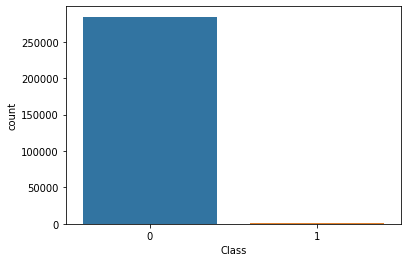

In [8]:
# Plot proporção do dataset - váriavel 'Class'
print('somente 0.17% (492) dos casos foram fraudes')

sns.countplot(x ='Class', data = df,)
 
plt.show()

O gráfico em formato de **violino** nos possibilita ter uma leitura mais aprofundada em comparação ao ***boxplot***, apresentando não somente a variação entre as observações mas também a **frequência (quanto mais largo maior o número de ocorrências).**

No caso abaixo, estamos considerando o valor das fraudes ('Class' = 1), podemos observar que a mediana está próxima de 0, assim como a maior frequência de casos varia entre 0 e 250 (provavelmente Euros).

Importante destacar a existência de valores outliers dentro do *dataset* (que será corrigido via normalização).

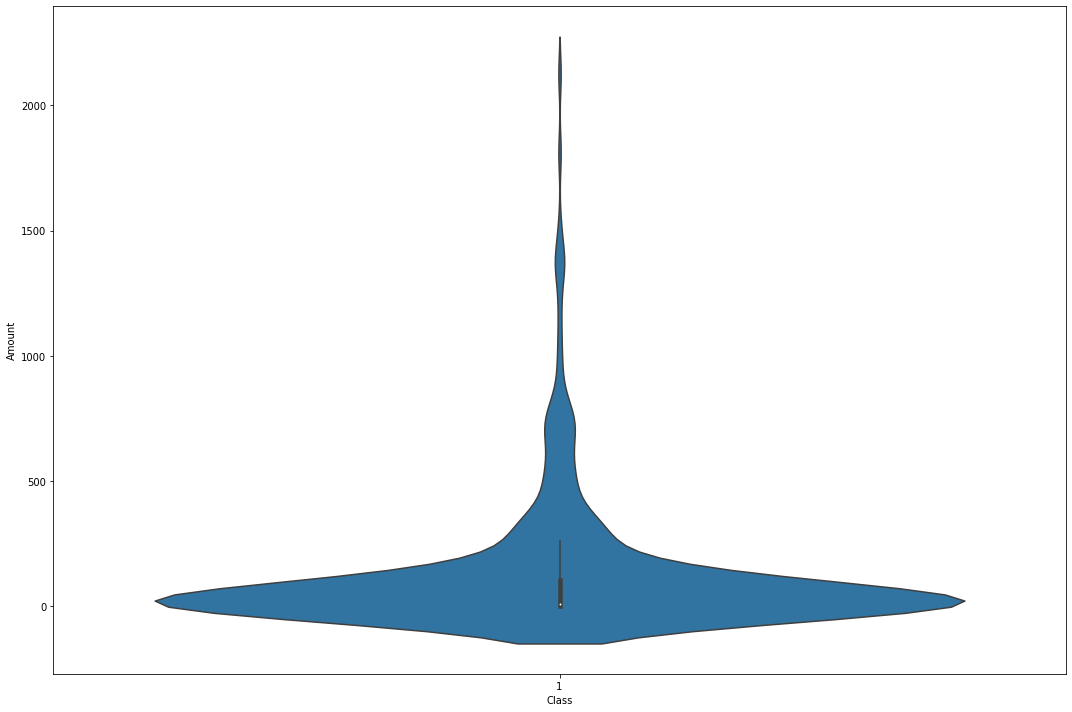

In [9]:
# Plot gráfico violino - variável 'Class' (quando for fraude = 1)

fig, ax = plt.subplots(figsize=(15,10))

sns.violinplot(data=df[df['Class'] == 1], x='Class', y='Amount', ax=ax);

plt.tight_layout()

Uma vez que as variáveis foram generalizadas, a leitura da **matriz de correlação** acaba por ser artificial. Ainda assim, conseguimos observar features com maior correlação e possível explicação sobre casos em que a fraude foi identificada.

Três variáveis se destacaram ao apresentar maior correlaçao positiva com a variável alvo ('Class') e possívelmente nos auxiliando a identificar padrões de fraude, são elas: **V11, V4 e V2.**

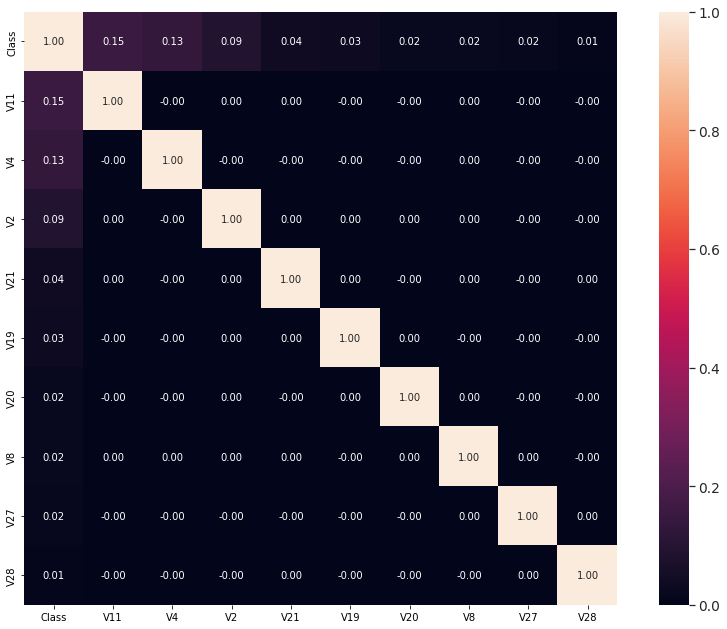

In [12]:
# criar uma matriz de correlação
df_corr = df.corr()

# mostrar a matriz de correlação
df_corr

# número de variáveis a serem selecionadas
k = 10

# encontrando as variáveis mais correlacionadas
cols = df_corr.nlargest(k, 'Class')['Class'].index
cm = np.corrcoef(df[cols].values.T)

# plotando o heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.tight_layout()

## **Preparação dos Dados**/***Feature Engineering***

1.   Normalização (*StandardScaler*) das features *'Time'* e *'Class'*
2.   Dividir o conjunto de dados entre treino e validação
3.   Balancear o conjunto de dados (*under-sampling*) - lembre-se que **somente 0.17%** das observações foram classificadas como fraudulentas

1. Normalização das colunas **Time** e **Amount**, utilizando do *StandardScaler* do próprio pacote do *Scikit-learn*.

In [13]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


2.  Divisão do dataset entre dados de treino e validação.

In [15]:
# separação do dataset entre treino e validação
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

3. Balanceamento dos dados preservando a classe minoritária (*under-sampling*).

No gráfico abaixo conseguimos ver que o problema da desproporção foi sanado.

1    370
0    370
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


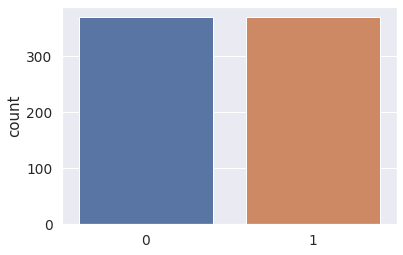

In [19]:
from imblearn.under_sampling import RandomUnderSampler;

# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train);

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts());

# plotar a nova distribuição de classes
sns.countplot(y_rus);

## **Modelo de Machine Learning**

Conforme mencionado no início do projeto, trabalharemos com dois modelos de classificação.

1. Regressão logística

In [37]:
# definição do modelo
model = LogisticRegression()

# fit do modelo
model.fit(X_rus, y_rus) # lembrar de selecionar o dataset balanceado

# fazer previsões em cima de novos dados
y_pred = model.predict(X_test)


2. Árvore de decisão

In [38]:
model2 = DecisionTreeClassifier(max_depth=4, criterion="entropy")

# 4. Fit do modelo (treinar)
model2.fit(X_rus, y_rus)

# 5. Fazer previsões em cima de novos dados
y_pred2 = model2.predict(X_test)


## **Avaliação dos modelos**

A definição da melhor métrica de avaliação passa por uma grande discussão e que irá variar conforme o problema apresentado. Existem diversos materiais  sobre o tema, segue [referência](https://towardsdatascience.com/=precision-vs-recall-evaluating-model-performance-in-credit-card-fraud-detection-bb24958b2723).

No nosso caso de estudo irei utilizar da métrica *recall*, priorizando pelo modelo que consegue nos indicar o maior número possível de casos positivos. Uma vez que a não identificação de fraude acarreta em custo para a instituição e para o usuário um grande estresse.

### *Recall*

$$
\frac{TP}{TP+FN}
$$

1. **Regressão logística**




In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71080
           1       0.05      0.92      0.09       122

    accuracy                           0.97     71202
   macro avg       0.52      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202



1. **Árvore de decisão**

In [49]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     71080
           1       0.02      0.91      0.04       122

    accuracy                           0.93     71202
   macro avg       0.51      0.92      0.50     71202
weighted avg       1.00      0.93      0.96     71202



## Conclusão

* O grande desafio do *dataset* está em lidar com a desproporção entre as classes, impactando na preparação dos dados e nos levando a diversas discussões sobre a melhor forma de avaliar os modelos.
* Outro processo importante, feito anteriormente, foi a redução das dimensionalidades, trazendo ainda mais complexidade para manipulação e análise das variáveis. Em um mundo real, o caminho inverso teria de ser feito para habilitar explicações sobre as princípais features utilizadas pelos modelos (em especial, ao apresentar os resultados para áreas não conectadas com ciência de dados).
* Comparando os modelos, a regressão logística foi capaz de entregar um melhor resultado - otimizando o número de fraudes identificadas (92%) e diminuíndo o número de compras não fraudulentas bloqueadas (3%).